## Load in the data and have it ready for use

In [16]:
import pandas as pd
import numpy as np
from pathlib import Path

data = Path("./data/M3_2nights_rawPhotometry.csv")
df = pd.read_csv(data, usecols=("Name  ", "Mag   ", "Error ", "JD"))
df.columns = [x.strip() for x in df.columns]

## Fix any issues with the data

In [17]:
# Make sure columns are in proper types
df["Mag"] = pd.to_numeric(df["Mag"], errors="coerce")
df["Error"] = pd.to_numeric(df["Error"], errors="coerce")
df["Time"] = pd.to_datetime(df["JD"], unit='D', origin='julian')
df["JD"] = pd.to_numeric(df["JD"], errors="coerce")
# Clean up NaN and duplicates
df = df.dropna(how="all")
df = df.drop_duplicates()
# Remove any entries without the most common number of datapoints
mode = df.groupby("Name").count().mode().values[0]
counted = df.groupby("Name").count()
good_stars = counted[(counted == mode).all(1)].index.values
df = df[df["Name"].isin(good_stars)]


## Differential Photometry and error propagation

In [18]:
def diff_phot(star, df):
    other_stars = df[df["Name"] != star.name]
    star_mag = star["Mag"].values
    other_mags = other_stars["Mag"].values
    star_error = star["Error"].values
    other_errors = other_stars["Error"].values
    N = len(other_mags) + 1
    num_stars = other_stars["Name"].nunique()
    rows = other_stars.shape[0]
    samples = int(rows / num_stars)
    shape = (samples, num_stars)
    other_mags = other_mags.reshape(shape).transpose()
    other_errors = other_errors.reshape(shape).transpose()
    star["DMag"] = np.mean((other_mags - star_mag), axis=0).ravel()
    star["DError"] = np.sqrt(np.sum(other_errors**2 + star_error**2, axis=0))/N
    return star
    

df = df.groupby("Name").apply(diff_phot, df)

## Exploratory data analysis

### Add calculated data to dataframe

In [19]:
def w_avg(df, values, weights):
    d = df[values]
    w = df[weights]
    df["DAvg"] = (d * w).sum() / w.sum()
    return df
df = df.groupby("Name").apply(w_avg, values="DMag", weights="DError")
df["DResid"] = df["DMag"] - df["DAvg"]
df["DDSquare"] = df["DResid"]**2

### Add variability data to dataframe

In [20]:
from scipy.stats import kurtosis, skew
def is_variable(df, values, threshold):
    df["Variable"] = df[values].mean() >= threshold
    return df
average_DDSquare = df["DDSquare"].mean()
df = df.groupby("Name").apply(is_variable, values="DDSquare", threshold=average_DDSquare)


### List variable stars

In [21]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

unique_stars = np.unique(df[df["Variable"] == True]["Name"])
print(f"Variable Stars: {', '.join(unique_stars)}")
print(f"Number of variable stars detected: {len(unique_stars)}")

Variable Stars: M3-1, M3-10, M3-11, M3-14, M3-15, M3-16, M3-17, M3-170, M3-19, M3-2, M3-217, M3-27, M3-3, M3-39, M3-4, M3-40, M3-45, M3-5, M3-6, M3-75, M3-88
Number of variable stars detected: 21


<AxesSubplot:xlabel='JD', ylabel='DMag'>

Star Delta Square residuals: 0.0016072602883306342
Star D'Agostino-Pearson (Normal) test results: NormaltestResult(statistic=1.3923802706405484, pvalue=0.4984808351670005)
Star kurtosis results: 0.45402848021966324
Star skew results: 0.000899788824979189


<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

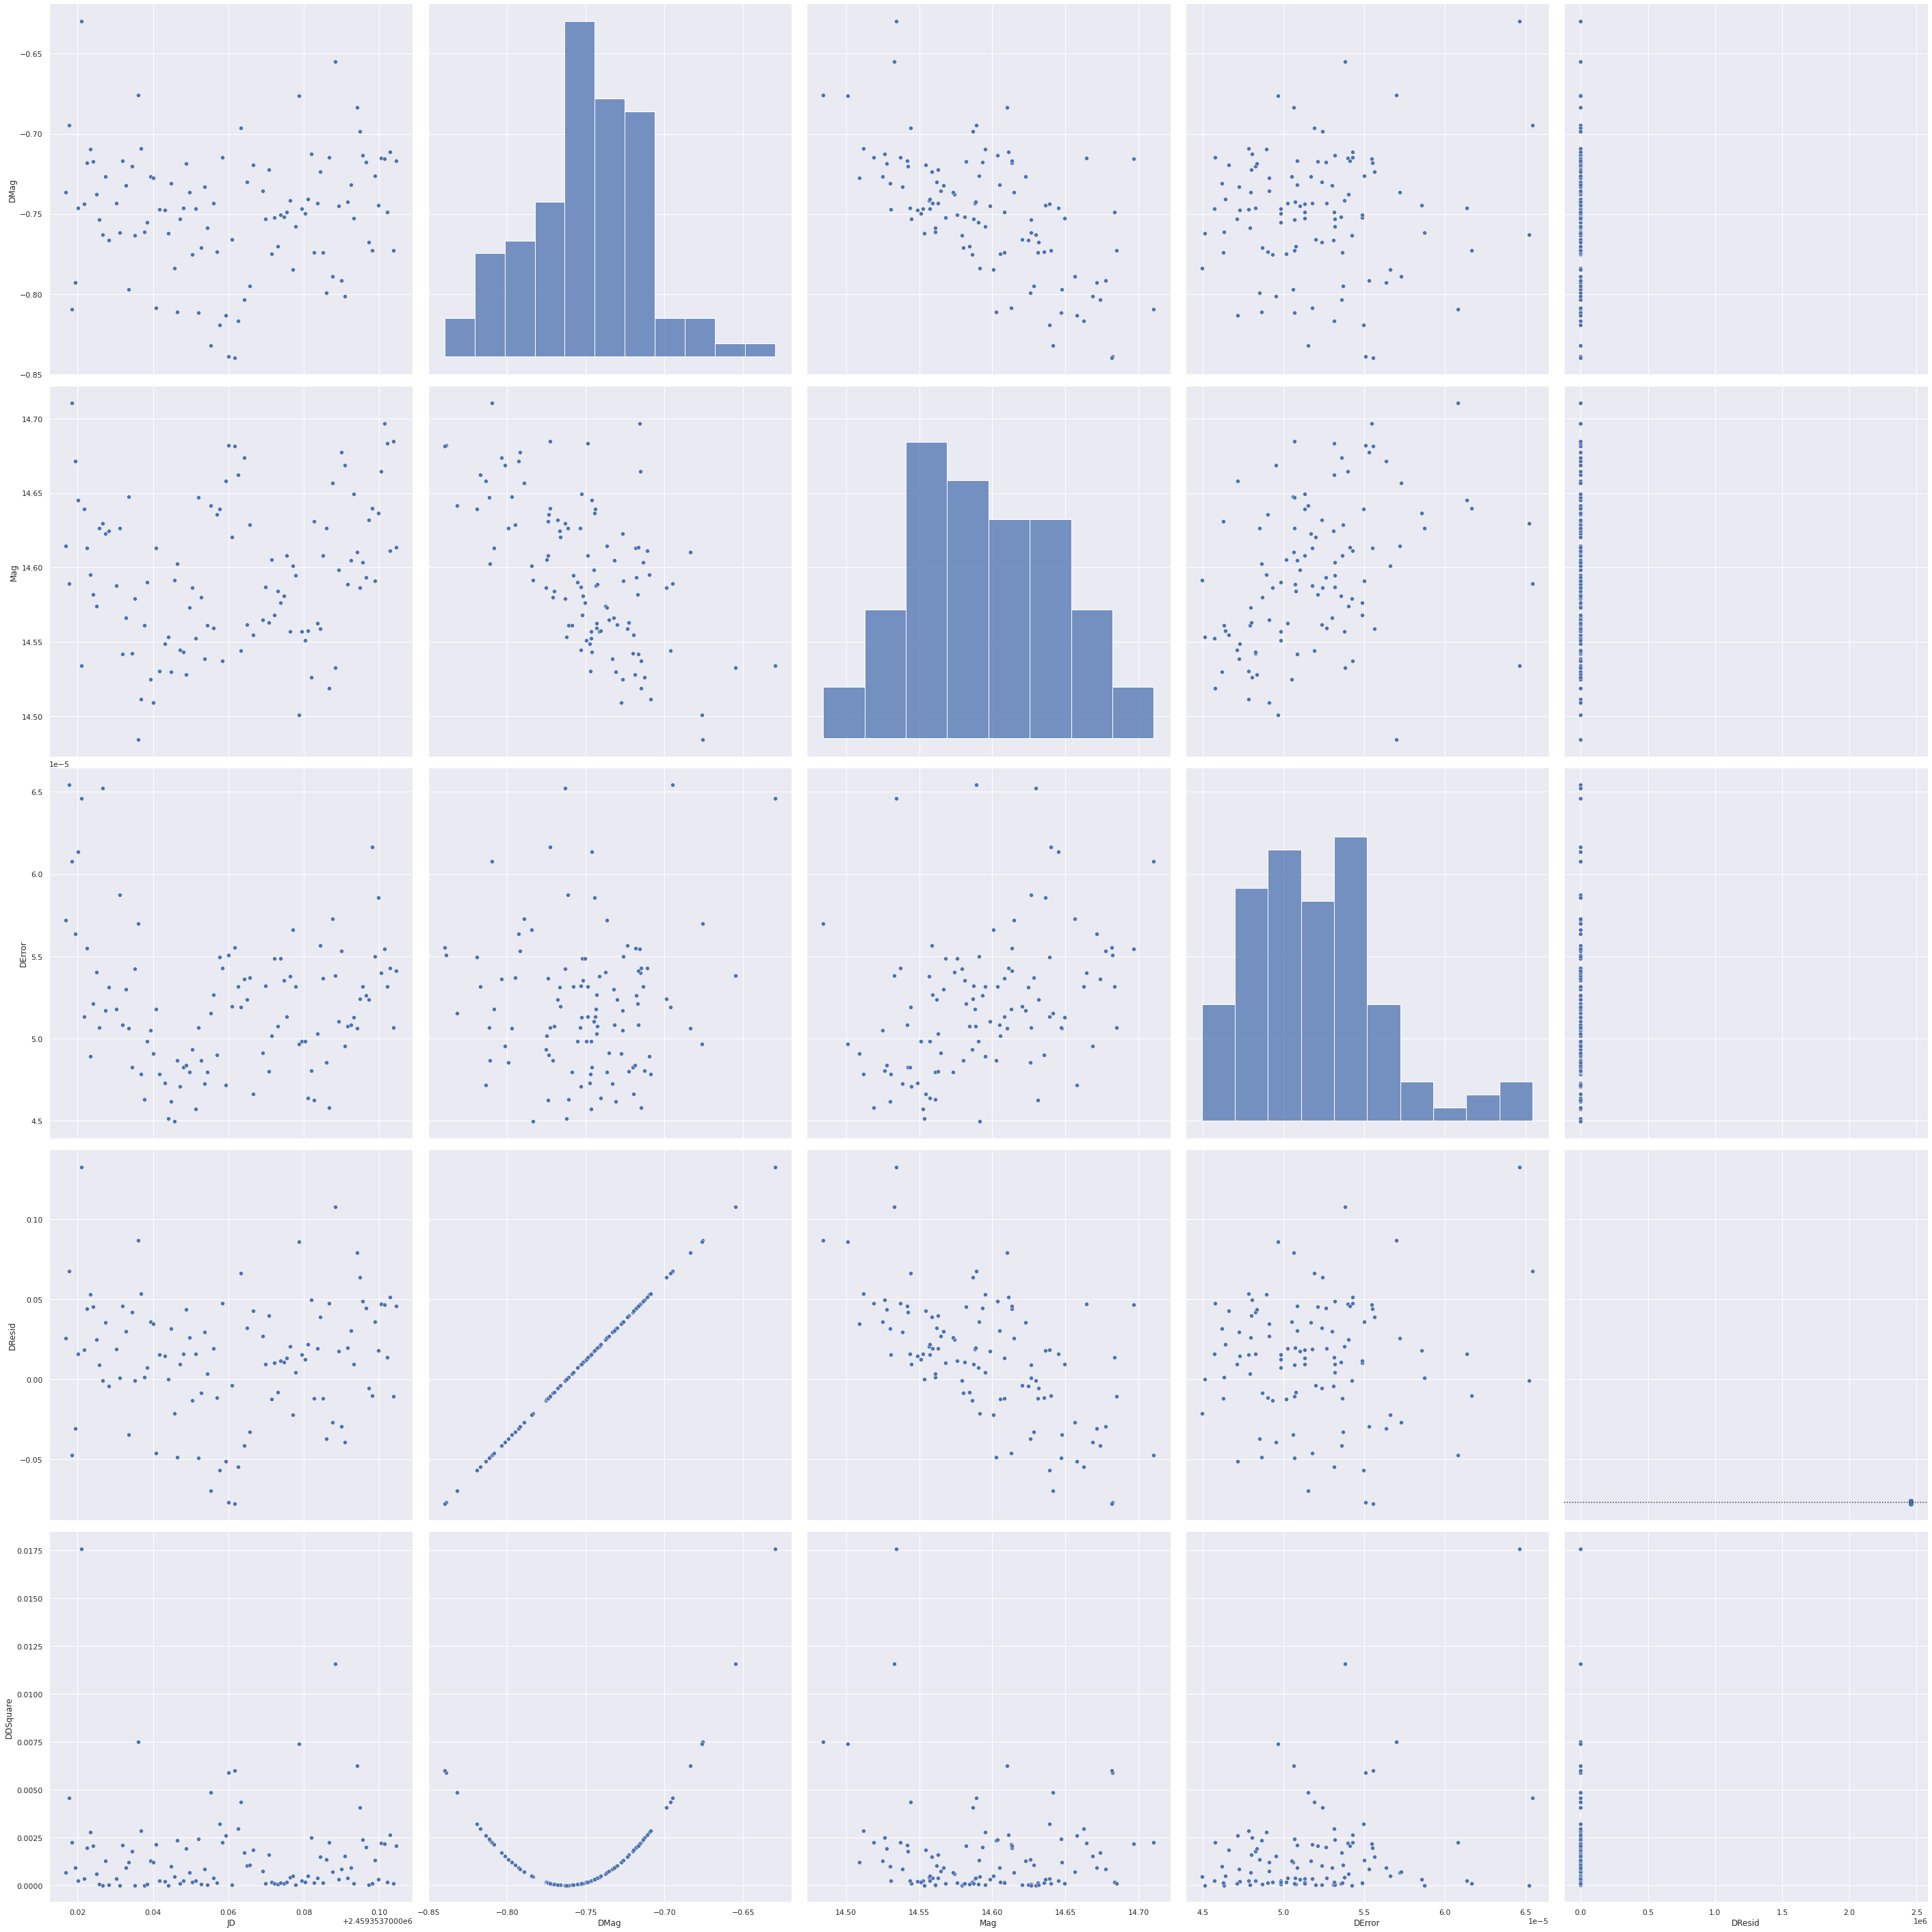

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import shapiro, normaltest
sns.set_theme(style="darkgrid")
fig1 = plt.figure(figsize=(12,8))
fig2 = plt.figure(figsize=(12,8))
star_name = "M3-112"

star = df[(df["Name"] == star_name) & (df["Time"].dt.day == 19)].copy()
#sns.scatterplot(data=star, x="Time", y="DResid", ax=fig1.gca())
#sm.graphics.plot_regress_exog(model, 'DMag', fig=fig2)
sns.pairplot(star, x_vars=["JD", "DMag","Mag", "DError", "DResid"], y_vars=["DMag", "Mag", "DError", "DResid",  "DDSquare"], height=8)
sns.residplot(data=star, x="JD", y="DMag")
d_square_sum_residuals = star["DDSquare"].mean()
k = kurtosis(star["DResid"], fisher=True)
s = skew(star["DResid"])
print(f"Star Delta Square residuals: {d_square_sum_residuals}")
print(f"Star D'Agostino-Pearson (Normal) test results: {normaltest(star['DResid'])}")
print(f"Star kurtosis results: {k}")
print(f"Star skew results: {s}") 

In [14]:
from functools import partial
fisher_k = partial(kurtosis, fisher=True)
df.groupby(["Variable", "Name"]).agg({"DResid": [fisher_k, "mean", skew, "std", "var", "mad"], "DDSquare" : [fisher_k, "mean", skew, "std", "var", "mad"]}).groupby("Variable").mean()

DResid                                                    \
          kurtosis      mean      skew       std       var       mad   
Variable                                                               
False     1.116945 -0.000678 -0.068516  0.043958  0.002289  0.035246   
True     -0.494117  0.024705 -0.291829  0.218943  0.063279  0.189336   

           DDSquare                                                    
           kurtosis      mean      skew       std       var       mad  
Variable                                                               
False     15.956190  0.002279  2.961183  0.003732  0.000045  0.002141  
True       8.334784  0.064742  2.082199  0.058370  0.006251  0.041710